In [ ]:
#|hide
#|default_exp pyrnet

# PyrNet high level data
In the following high-level functions to read and examine PyrNet data are collected.

In [2]:
#|export
from collections.abc import Iterable
from xml.dom import minidom
from urllib.request import urlopen
import parse
import os
import numpy as np
import pandas as pd
import xarray as xr
from scipy.interpolate import interp1d
from toolz import valfilter, cons, merge, merge_with
import pkg_resources as pkg_res
import warnings

# python -m pip install git+https://github.com/hdeneke/trosat-base.git#egg=trosat-base
from trosat import sunpos as sp

from pyrnet import utils as pyrutils

In [3]:
# extra imports for demonstration
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt

## Load Data from Thredds-Server
Acquire processed data from server

In [4]:
#|export
# campaign file name map for hdcp2 data
campaign_pfx = {
    'eifel': 'hope',
    'hope_juelich': 'hope',
    'hope_melpitz': 'hopm',
    'lindenberg': 'ioprao',
    'melcol': 'mcol',
}

# TROPOS thredds urls templates
DATA_URL = "https://tds.tropos.de/thredds/dodsC/scccJher/{dt:%Y}_{campaign}/"
FNAME_FMT_HDCP2 = '{campaign_pfx}_trop_pyrnet00_l1_rsds_v00_{dt:%Y%m%d}000000.nc'

# configuration constants
SOLCONST = 1359.0 # Solar constant in Wm-2
MAX_MISSING = 1000 # Maximum allowed number of missing records
MIN_GOOD = 85400 # Minimum allowed number of good records


### Thredds lookups

In [5]:
#|export
#|dropcode
def get_elements(url, tag_name='dataset', attribute_name='urlPath'):
  """Get elements from an XML file"""
  # usock = urllib2.urlopen(url)
  usock = urlopen(url)
  xmldoc = minidom.parse(usock)
  usock.close()
  tags = xmldoc.getElementsByTagName(tag_name)
  attributes=[]
  for tag in tags:
    attribute = tag.getAttribute(attribute_name)
    attributes.append(attribute)
  return attributes

def parse_thredds_catalog(url, fname_format):
    """Parse Thredds server catalog and return pd.Dataframe of file name format variables."""
    fname_format = fname_format.replace("%Y-%m-%d","ti")
    tfiles = get_elements(url)
    results = False
    for fn in tfiles:
        fn = os.path.basename(fn)
        res = parse.parse(fname_format, fn)
        if res is None:
            continue
        if not results:
            results = {k:[v] for k,v in res.named.items()}
        else:
            results = merge_with(lambda x: list(cons(x[1],x[0])), results, res.named)
    return pd.DataFrame.from_dict(results)

def lookup_fnames(date, *, station, lvl, campaign, collection):
    """Parse Thredds server files and return list of filenames matching the date, station, campaign and collection configuration."""
    date = pyrutils.to_datetime64(date)

    fn = pkg_res.resource_filename("pyrnet", "share/pyrnet_config.json")
    pyrcfg = pyrutils.read_json(fn)

    # construct catalog url
    catalog_url = DATA_URL.format(dt=pd.to_datetime(date),campaign=campaign)
    catalog_url = catalog_url.replace("dodsC","catalog")
    catalog_url += f"{lvl}/catalog.xml"
    catalog = parse_thredds_catalog(catalog_url, pyrcfg[f"output_{lvl}"])

    if station is None:
        try:
            nlvl = f"{lvl}_network"
            c = parse_thredds_catalog(catalog_url.replace(f"/{lvl}/",f"/{nlvl}/"),
                                      pyrcfg[f"output_{nlvl}"])
            c = c.query(f"dt=='{pd.to_datetime(date):%Y-%m-%d}'")
            if c.size==0:
                raise ValueError
            if collection is None:
                col = np.nanmax(c['collection'])
            else:
                col = collection
            fnames = [
                pyrcfg[f"output_{nlvl}"].format(
                    dt=pd.to_datetime(date),
                    campaign=campaign,
                    collection=col,
                    sfx="nc"
                )
            ]
            url = DATA_URL.format(dt=pd.to_datetime(date),campaign=campaign)
            fnames = [url + f"{nlvl}/"+ fn for fn in fnames]
            return fnames
        except:
            station = np.unique(catalog["station"].values)

    if not isinstance(station, Iterable):
        station=[station]

    # file name blueprint

    fnames = []
    for st in station:
        c = catalog.query(f'station=={st}').reset_index()
        if c.size==0:
            warnings.warn(f"File of station {st} does not exist.")
            continue

        if collection is None:
            col = np.nanmax(c['collection'])
        else:
            col = collection

        c = c.query(f"collection=={col}").reset_index()
        if c.size==0:
            warnings.warn(f"File of station {st}, collection {col} does not exist.")
            continue

        if lvl=='l1a':
            c = catalog.query(f'station=={st} & collection=={col}').reset_index()
            startdts = c["startdt"]
            enddts = c["enddt"]
            # get file index with maintenance interval including date
            idate_start = np.sum(date>=startdts)-1
            idate_end = np.sum(date>enddts)
            if (idate_start==-1) or (idate_end==enddts.size):
                warnings.warn(f"File of station {st}, level {lvl} at date {date} does not exist.")
                continue

            fnames.append(
                pyrcfg[f"output_{lvl}"].format(
                    startdt=pd.to_datetime(startdts[idate_end]),
                    enddt=pd.to_datetime(enddts[idate_end]),
                    campaign=campaign,
                    station=st,
                    collection=col,
                    sfx="nc"
                )
            )
            if idate_end!=idate_start: # date is on a maintenance day -> combine two datasets
                fnames.append(
                    pyrcfg[f"output_{lvl}"].format(
                        startdt=pd.to_datetime(startdts[idate_start]),
                        enddt=pd.to_datetime(enddts[idate_start]),
                        campaign=campaign,
                        station=st,
                        collection=col,
                        sfx="nc"
                    )
                )

        else:
            c = c.query(f"dt=='{pd.to_datetime(date):%Y-%m-%d}'")
            if c.size==0:
                warnings.warn(f"File of station {st}, collection {col} at date {date} does not exist.")
                continue
            fnames.append(
                pyrcfg[f"output_{lvl}"].format(
                    dt=pd.to_datetime(date),
                    campaign=campaign,
                    station=st,
                    collection=col,
                    sfx="nc"
                )
            )
    url = DATA_URL.format(dt=pd.to_datetime(date),campaign=campaign)
    fnames = [url + f"{lvl}/"+ fn for fn in fnames]
    return fnames

In [6]:
#|dropout
# date = dt.date(2019,8,7)
# campaign='metpvnet'
# lvl='l1b'
# 
# # construct catalog url
# url = DATA_URL.format(dt=pd.to_datetime(date),campaign=campaign)
# url = url.replace("dodsC","catalog")
# url += f"{lvl}/catalog.xml"
# 
# tfiles = get_elements(url)
# tfiles

['',
 'scccJher/2019_metpvnet/l1b/pyrnet_2019-08-07_metpvnet_st087_l1b.c01.nc',
 'scccJher/2019_metpvnet/l1b/pyrnet_2019-08-07_metpvnet_st086_l1b.c01.nc',
 'scccJher/2019_metpvnet/l1b/pyrnet_2019-08-07_metpvnet_st060_l1b.c01.nc',
 'scccJher/2019_metpvnet/l1b/pyrnet_2019-08-07_metpvnet_st055_l1b.c01.nc',
 'scccJher/2019_metpvnet/l1b/pyrnet_2019-08-07_metpvnet_st053_l1b.c01.nc',
 'scccJher/2019_metpvnet/l1b/pyrnet_2019-08-07_metpvnet_st047_l1b.c01.nc',
 'scccJher/2019_metpvnet/l1b/pyrnet_2019-08-07_metpvnet_st046_l1b.c01.nc',
 'scccJher/2019_metpvnet/l1b/pyrnet_2019-08-07_metpvnet_st044_l1b.c01.nc',
 'scccJher/2019_metpvnet/l1b/pyrnet_2019-08-07_metpvnet_st043_l1b.c01.nc',
 'scccJher/2019_metpvnet/l1b/pyrnet_2019-08-07_metpvnet_st038_l1b.c01.nc',
 'scccJher/2019_metpvnet/l1b/pyrnet_2019-08-07_metpvnet_st035_l1b.c01.nc',
 'scccJher/2019_metpvnet/l1b/pyrnet_2019-08-07_metpvnet_st033_l1b.c01.nc',
 'scccJher/2019_metpvnet/l1b/pyrnet_2019-08-07_metpvnet_st032_l1b.c01.nc',
 'scccJher/2019_metp

In [7]:
#|dropout
fn = pkg_res.resource_filename("pyrnet", "share/pyrnet_config.json")
pyrcfg = pyrutils.read_json(fn)
# catalog = parse_thredds_catalog(url,pyrcfg["output_l1b"])
# catalog.query('station==10')

dt  campaign  station  collection sfx
21   2019-06-26  metpvnet       10           1  nc
45   2019-06-27  metpvnet       10           1  nc
71   2019-06-28  metpvnet       10           1  nc
97   2019-06-29  metpvnet       10           1  nc
123  2019-06-30  metpvnet       10           1  nc
149  2019-07-01  metpvnet       10           1  nc
175  2019-07-02  metpvnet       10           1  nc
201  2019-07-03  metpvnet       10           1  nc
227  2019-07-04  metpvnet       10           1  nc
253  2019-07-05  metpvnet       10           1  nc
279  2019-07-06  metpvnet       10           1  nc
305  2019-07-07  metpvnet       10           1  nc
331  2019-07-08  metpvnet       10           1  nc
357  2019-07-09  metpvnet       10           1  nc
382  2019-07-10  metpvnet       10           1  nc
407  2019-07-11  metpvnet       10           1  nc
432  2019-07-12  metpvnet       10           1  nc
457  2019-07-13  metpvnet       10           1  nc
482  2019-07-14  metpvnet       10           1  nc
507  2019-07-15  metpvnet       10           1  nc
532  2019-07-16  metpvnet       10           1  nc
556  2019-07-17  metpvnet       10           1  nc
580  2019-07-18  metpvnet       10           1  nc
604  2019-07-19  metpvnet       10           1  nc
628  2019-07-20  metpvnet       10           1  nc
652  2019-07-21  metpvnet       10           1  nc
676  2019-07-22  metpvnet       10           1  nc
700  2019-07-23  metpvnet       10           1  nc
725  2019-07-24  metpvnet       10           1  nc
749  2019-07-25  metpvnet       10           1  nc
773  2019-07-26  metpvnet       10           1  nc
797  2019-07-27  metpvnet       10           1  nc
821  2019-07-28  metpvnet       10           1  nc
845  2019-07-29  metpvnet       10           1  nc
869  2019-07-30  metpvnet       10           1  nc
894  2019-07-31  metpvnet       10           1  nc
919  2019-08-01  metpvnet       10           1  nc
943  2019-08-02  metpvnet       10           1  nc
967  2019-08-03  metpvnet       10           1  nc
991  2019-08-04  metpvnet       10           1  nc
1015 2019-08-05  metpvnet       10           1  nc
1039 2019-08-06  metpvnet       10           1  nc
1063 2019-08-07  metpvnet       10           1  nc

In [8]:
# catalog.query('dt=="2019-07-05"')

dt  campaign  station  collection sfx
250 2019-07-05  metpvnet        5           1  nc
251 2019-07-05  metpvnet        7           1  nc
252 2019-07-05  metpvnet        9           1  nc
253 2019-07-05  metpvnet       10           1  nc
254 2019-07-05  metpvnet       12           1  nc
255 2019-07-05  metpvnet       14           1  nc
256 2019-07-05  metpvnet       15           1  nc
257 2019-07-05  metpvnet       18           1  nc
258 2019-07-05  metpvnet       24           1  nc
259 2019-07-05  metpvnet       25           1  nc
260 2019-07-05  metpvnet       26           1  nc
261 2019-07-05  metpvnet       32           1  nc
262 2019-07-05  metpvnet       33           1  nc
263 2019-07-05  metpvnet       35           1  nc
264 2019-07-05  metpvnet       37           1  nc
265 2019-07-05  metpvnet       38           1  nc
266 2019-07-05  metpvnet       43           1  nc
267 2019-07-05  metpvnet       44           1  nc
268 2019-07-05  metpvnet       46           1  nc
269 2019-07-05  metpvnet       47           1  nc
270 2019-07-05  metpvnet       53           1  nc
271 2019-07-05  metpvnet       54           1  nc
272 2019-07-05  metpvnet       55           1  nc
273 2019-07-05  metpvnet       60           1  nc
274 2019-07-05  metpvnet       86           1  nc
275 2019-07-05  metpvnet       87           1  nc

In [9]:
#|dropout
lvl='l1a'
station=[86,87,88]
date = dt.datetime(2019,7,31)
campaign = 'metpvnet'
collection= None

# lookup_fnames(date,station=station,lvl=lvl,campaign=campaign,collection=collection)

/tmp/ipykernel_470/1870864409.py:80: UserWarning: File of station 88 does not exist.
  warnings.warn(f"File of station {st} does not exist.")


['https://tds.tropos.de/thredds/dodsC/scccJher/2019_metpvnet/l1a/pyrnet_2019-07-24_2019-07-31_metpvnet_st086_l1a.c01.nc',
 'https://tds.tropos.de/thredds/dodsC/scccJher/2019_metpvnet/l1a/pyrnet_2019-07-31_2019-08-07_metpvnet_st086_l1a.c01.nc',
 'https://tds.tropos.de/thredds/dodsC/scccJher/2019_metpvnet/l1a/pyrnet_2019-07-30_2019-08-07_metpvnet_st087_l1a.c01.nc']

#### Example Reading multiple days and stations from Thredds

In [10]:
#|dropout
#|dropcode
# lvl='l1b'
# stations = None
# stations = [8,9]
# dates = [dt.datetime(2013,4,10),dt.datetime(2013,4,9)]
# campaign = 'hope_juelich'
# collection= None
# 
# if not isinstance(dates,Iterable):
#     dates = [dates]
# fnames = []
# for date in dates:
#     fnames.extend(
#         lookup_fnames(
#             date=date,
#             station=stations,
#             lvl=lvl,
#             campaign=campaign,
#             collection=collection
#         )
#     )
# urls = np.unique(fnames)
# urls

array(['https://tds.tropos.de/thredds/dodsC/scccJher/2013_hope_juelich/l1b/pyrnet_2013-04-09_hope_juelich_st008_l1b.c01.nc',
       'https://tds.tropos.de/thredds/dodsC/scccJher/2013_hope_juelich/l1b/pyrnet_2013-04-09_hope_juelich_st009_l1b.c01.nc',
       'https://tds.tropos.de/thredds/dodsC/scccJher/2013_hope_juelich/l1b/pyrnet_2013-04-10_hope_juelich_st008_l1b.c01.nc',
       'https://tds.tropos.de/thredds/dodsC/scccJher/2013_hope_juelich/l1b/pyrnet_2013-04-10_hope_juelich_st009_l1b.c01.nc'],
      dtype='<U114')

In [11]:
#|dropout
#|dropcode
# stations = np.arange(1,101)
# for i,url in enumerate(urls):
#     # read from thredds server
#     dst = xr.open_dataset(url)
# 
#     # drop not needed variables
#     # keep_vars = ['ghi','gti','szen']
#     # drop_vars = [v for v in dst if v not in keep_vars]
#     # dst = dst.drop_vars(drop_vars)
# 
#     # unify time and station dimension to speed up merging
#     date = dst.time.values[0].astype("datetime64[D]")
#     timeidx = pd.date_range(date, date + np.timedelta64(1, 'D'), freq='1s', inclusive='left')
#     dst = dst.interp(time=timeidx)
#     dst = dst.reindex({"station": stations})
# 
#     # add gti for single stations
#     if "gti" not in dst:
#         dst = dst.assign({
#             "gti": (("time","station"), np.full(dst.ghi.values.shape,np.nan))
#         })
# 
#     # merge
#     if i == 0:
#         ds = dst.copy()
#     else:
#         ds = xr.concat((ds,dst),dim='time', data_vars='minimal', coords='minimal', compat='override')
# ds = ds.dropna(dim="station",how='all')

In [12]:
#|dropout
#|dropcode
# ds

<xarray.Dataset>
Dimensions:          (station: 2, time: 345600)
Coordinates:
  * station          (station) int64 8 9
  * time             (time) datetime64[ns] 2013-04-09 ... 2013-04-10T23:59:59
Data variables:
    lat              (station) float64 50.91 nan
    lon              (station) float64 6.405 nan
    ghi_qc           (station) float32 0.0 nan
    esd              (station) float32 1.001 nan
    ghi              (time, station) float64 0.0 nan 0.0 nan ... nan nan nan nan
    ta               (time, station) float64 276.5 nan 276.5 nan ... nan nan nan
    rh               (time, station) float64 0.6134 nan 0.6128 ... nan nan nan
    battery_voltage  (time, station) float64 4.917 nan 4.912 nan ... nan nan nan
    szen             (time, station) float64 121.3 nan 121.3 nan ... nan nan nan
    sazi             (time, station) float64 6.95 nan 6.95 nan ... nan nan nan
    gti              (time, station) float64 nan nan nan nan ... nan nan nan nan
Attributes: (12/30)
    title:                     TROPOS pyranometer network (PyrNet) observations
    institution:               Leibniz Institute for Tropospheric Research (T...
    department:                Remote Sensing of Atmospheric Processes
    department_team:           Clouds, Aerosol and Radiation
    address:                   Permoser Str. 15, 04318 Leipzig, Germany
    source:                    TROPOS pyranometer network (PyrNet)
    ...                        ...
    geospatial_lon_max:        6.404585328091691
    geospatial_lon_units:      degE
    time_coverage_start:       2013-04-09T00:00:00
    time_coverage_end:         2013-04-09T23:59:59
    time_coverage_duration:    P0DT23H59M59S
    time_coverage_resolution:  P0DT0H0M1S

### Data processed by the pyrnet package
Data (re-)processed by the pyrnet package is available at the TROPOS thredds server. The following function grant easy access.

1. Filename lookup on thredds server:

In [13]:
#|export
#|dropcode

def read_thredds(dates, *, campaign, stations=None, lvl='l1b', collection=None, freq="1s", drop_vars=None):
    """
    Read PyrNet data (processed with pyrnet package) from the TROPOS thredds server. Returns one xarray Dataset merged to match the dates and stations input.
    Parameters
    ----------
    dates: list, ndarray, or scalar of type float, datetime or datetime64
        A representation of time. If float, interpreted as Julian date.
    campaign: str
        Campaign identifier.
    stations: list, ndarray, or scalar of type int or None
        PyrNet station numbers. If None, read all stations available.
    lvl: str
        Data processing level -> 'l1a', 'l1b'. The default is 'l1b'.
    collection: int or None
        Collection number. If None, the latest available collection is looked up. The default is None.
    freq: str
        Pandas date frequencey description string. The default is '1s'.
    drop_vars: list of string or None
        List of variables to drop from datasets to speed up merging process.

    Returns
    -------
    xarray.Dataset
        Merged Dataset including all dates and stations specified by the input.
    """

    if not isinstance(dates, Iterable):
        dates = [dates]

    if lvl=='l1a':
        timevar = 'gpstime'
    elif lvl=='l1b':
        timevar = 'time'
    else:
        raise ValueError(f"lvl {lvl} not implemented.")

    fnames = []
    for date in dates:
        fnames.extend(
            lookup_fnames(
                date=date,
                station=stations,
                lvl=lvl,
                campaign=campaign,
                collection=collection
            )
        )
    urls = np.unique(fnames)

    if len(urls)==0:
        return None

    stations = np.arange(1,101)
    for i,url in enumerate(urls):
        # read from thredds server
        dst = xr.open_dataset(url)

        # drop not needed variables
        if drop_vars is not None:
            dst = dst.drop_vars(drop_vars)

        # unify time and station dimension to speed up merging
        date = dst[timevar].values[0].astype("datetime64[D]")
        timeidx = pd.date_range(date, date + np.timedelta64(1, 'D'), freq=freq, inclusive='left')
        dst = dst.reindex({timevar: timeidx}, method='nearest',tolerance=np.timedelta64(1,'ms'))
        dst = dst.reindex({"station": stations})

        # add gti for single stations
        if "gti" not in dst:
            dst = dst.assign({
                "gti": (dst.ghi.dims, np.full(dst.ghi.values.shape,np.nan)),
                "qc_flag_gti": (dst.qc_flag_ghi.dims, np.full(dst.qc_flag_ghi.values.shape,0)),
                "maintenance_flag_gti": (dst.maintenance_flag_ghi.dims, np.full(dst.maintenance_flag_ghi.values.shape,0))
            })

        # merge
        if i == 0:
            ds = dst.copy()
        else:
            overwrite_vars = [v for v in dst if timevar not in dst[v].dims]
            # ds = ds.concat(dst,dim='time',
            #                data_vars='minimal',
            #                coords='minimal',
            #                overwrite_vars=overwrite_vars)
            ds = ds.merge(dst,
                          compat='no_conflicts',
                          overwrite_vars=overwrite_vars)
            dst.close()
    ds = ds.dropna(dim="station",how='all')
    return ds

In [14]:
# ds = xr.open_dataset(urls[0])
# for url in urls[1:]:
#     dst = xr.open_dataset(url)
#     st = dst.station.values[0]
#     stime = dst.time
#     if st not in ds.station.values:
#         ds = xr.concat((ds,dst), dim="station", coords="minimal")
#     elif dst.time.values[0] not in ds.time.values:
#         ds = xr.concat((ds,dst), dim="time", coords="minimal")
#     elif dst.time.values[0] not in ds.sel(station=st).dropna("time").time.values:
#         ds = xr.merge((ds,dst))
#     else:
#         continue
# ds

### Data processed during HDCP2
During HDCP2 the raw Pyrnet data was processed with several IDL scripts manually. It is a legacy dataset, which can be accessed under the *old* directory on the Thredds server, as follows:

In [15]:
#|export
def read_hdcp2( dt, fill_gaps=True, campaign='hope_juelich'):
    """
    Read HDCP2-formatted datafiles from the pyranometer network

    Parameters
    ----------
    dt: datetime.date
        The date of the data to read
    fill_gaps: bool
        A flag indicating whether gaps should be filled by interpolation
    campaign: str
        specify campaign ['eifel','hope_juelich','hope_melpitz','lindenberg','melcol']

    Returns
    -------
    dataset : xarray.Dataset
        The pyranometer network observations
    """
    # load dataset
    fname = DATA_URL + "old/nc/"+ FNAME_FMT_HDCP2
    fname = fname.format(dt=dt,
                         campaign=campaign,
                         campaign_pfx=campaign_pfx[campaign])
    ds = xr.open_dataset(fname, mask_and_scale=False)

    # select good stations
    igood = (np.sum(ds.rsds.data<-900.0,axis=0)<MAX_MISSING)&(np.sum(ds.rsds_flag==1,axis=0)>MIN_GOOD)
    ds = ds.isel(nstations=igood)

    # fill gaps if requested
    if fill_gaps==True:
        x = (ds.time-ds.time[0])/np.timedelta64(1,'s')
        for i in np.arange(ds.dims['nstations']):
            y = ds.rsds.data[:,i]
            m = y>-990.0
            if not np.all(m):
                f = interp1d(x[m],y[m],'linear',bounds_error=False,fill_value='extrapolate')
                ds.rsds[~m,i]=f(x[~m])
    # add additional DataArrays
    jd = (ds.time.data-np.datetime64(sp.EPOCH_JD2000_0))/np.timedelta64(1,'D')
    ds['esd'] = sp.earth_sun_distance(jd[0]+0.5)
    szen = sp.sun_angles(jd[:,None],ds.lat.data[None,:],ds.lon.data[None,:])[0]
    ds['szen']    = xr.DataArray(szen,dims=('time','nstations'),coords={'time':ds.time.data})
    ds['mu0']     = np.cos(np.deg2rad(ds.szen))
    ds['gtrans']  = ds.rsds/ds.esd**2/SOLCONST/ds['mu0']
    return ds.rename({'rsds_flag':'qaflag','rsds':'ghi'})

In [16]:
#|export
# read pyrnet data and add coordinates
def read_pyrnet(date, campaign):
    """ Read pyrnet data and add coordinates
    """
    pyr = read_hdcp2(date, campaign=campaign)
    x,y = pyrutils.get_xy_coords(pyr.lon,pyr.lat)
    pyr['x'] = xr.DataArray(x,dims=('nstations'))
    pyr['y'] = xr.DataArray(y,dims=('nstations'))
    return pyr

In [17]:
#|dropout
# date = dt.datetime(2013,7,15)
# pyr  = read_pyrnet(date, 'hope_juelich')
# pyr

<xarray.Dataset>
Dimensions:     (nstations: 52, time: 86400, nv: 2)
Coordinates:
  * time        (time) datetime64[ns] 2013-07-15 ... 2013-07-15T23:59:59
Dimensions without coordinates: nstations, nv
Data variables: (12/13)
    station_id  (nstations) int8 ...
    lon         (nstations) float32 6.408 6.381 6.405 6.386 ... 6.449 6.44 6.437
    lat         (nstations) float32 50.92 50.9 50.91 50.93 ... 50.89 50.89 50.88
    zag         float32 ...
    time_bnds   (time, nv) datetime64[ns] ...
    ghi         (time, nstations) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...          ...
    esd         float64 1.017
    szen        (time, nstations) float64 107.4 107.4 107.4 ... 107.6 107.6
    mu0         (time, nstations) float64 -0.2994 -0.2998 ... -0.3025 -0.3027
    gtrans      (time, nstations) float64 -0.0 -0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0
    x           (nstations) float64 -1.523e+03 -3.439e+03 ... 704.5 496.9
    y           (nstations) float64 2.869e+03 456.1 ... -321.2 -1.071e+03
Attributes:
    Title:            Shortwave broadband downwelling shortwave radiation (su...
    Institution:      Leibniz Institute for Tropospheric Research (TROPOS), L...
    Contact_person:   Andreas Macke (Email: andreas.macke@tropos.de)
    Source:           EKO Pyranometer (Model No: ML-020VM; EKO Instruments Co...
    History:          Data processed with WRITEPYRFLUXNC_6.pro IDL code at TR...
    Conventions:      CF-1.6 where applicable
    Processing_date:  File created on 2014-06-17, 13:35:33 UTC
    Author:           Madhavan Bomidi (Email: madhavan.bomidi@tropos.de)
    Comments:         HOPE-JUELICH Campaign (April 2013 - July 2013)
    License:          For non-commercial use only. This data is subject to th...

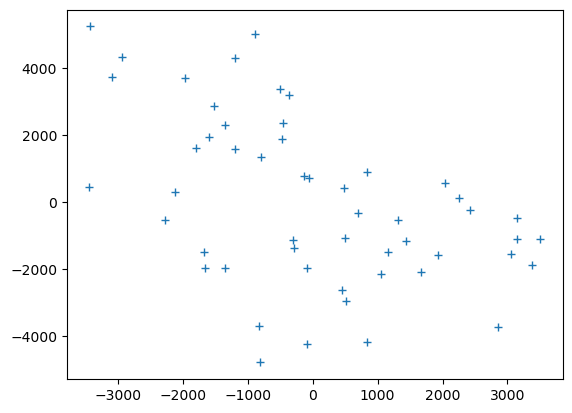

In [18]:
# plot pyranometer locations
# tstart = int(10.5*3600)
# tstop  = tstart+2*3600
# tslice = slice(tstart,tstop)
# 
# plt.figure()
# p = plt.plot(pyr.x.data,pyr.y.data,'+')

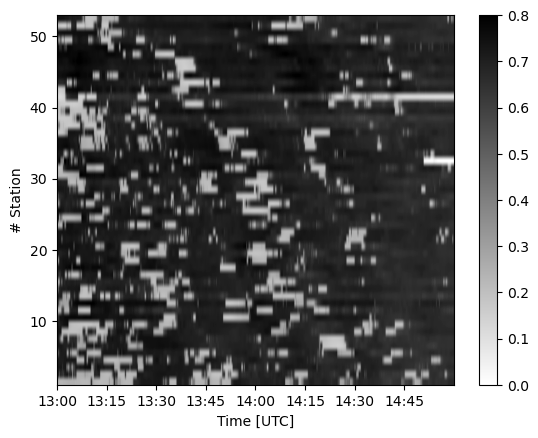

In [19]:
# tstart = int(13.0*3600)
# tstop  = tstart+2*3600
# tslice = slice(tstart,tstop)
# 
# tlim = [
#     mdates.date2num(pyr.time.data[tslice][0]),
#     mdates.date2num(pyr.time.data[tslice][-1])
# ]
# 
# fig,ax = plt.subplots(1,1)
# 
# i_sy = np.argsort(-pyr.y.data)
# im1 = ax.imshow(pyr.gtrans[tslice,i_sy].T, extent=[tlim[0],tlim[1], 1, 1+len(i_sy)], aspect="auto", cmap="gray_r", vmin=0.0, vmax=0.8)
# _ = ax.set_ylabel("# Station")
# 
# 
# date_fmt = mdates.DateFormatter('%H:%M')
# xticks = ax.get_xticks()
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(date_fmt)
# _ = ax.set_xlabel("Time [UTC]")
# fig.colorbar(im1, ax=ax)
# fig.show()

## Read Calibration Files
Calibration factors are collected in share/pyrnet_calibration.json. The following function looks up the nearest calibration in time and fill missing values with earlier calibrations

In [20]:
# pyrnet_calibration.json structure
calib = {
    "2017-04":{
        "001":[7.1,7.2],
        "002":[7.51,7.61],
        "003":[6.9,6.91]
    },
    "2019-04": {
        "001":[7,None],
        "002":[7.5,7.6]
    }
}

date1 = np.datetime64("2019-05-01") # closer to "2019-04" calibration
date2 = np.datetime64("2018-01-01") # closer to "2017-04" calibration

# parse calibration dates
cdates = pd.to_datetime(list(calib.keys())).values

# sort calib keys beginning with nearest
# skeys1 = np.array(list(calib.keys()))[np.argsort(np.abs(date1 - cdates))][::-1]
# skeys2 = np.array(list(calib.keys()))[np.argsort(np.abs(date2 - cdates))][::-1]

# lookup recents
isort = np.argsort(cdates)
skeys1 = np.array(list(calib.keys()))[isort][:np.sum(date1>cdates)]
skeys2 = np.array(list(calib.keys()))[isort][:np.sum(date2>cdates)]

print("Order of calibration lookup")
print(date1, '->' ,skeys1)
print(date2, '->' ,skeys2)

Order of calibration lookup
2019-05-01 -> ['2017-04' '2019-04']
2018-01-01 -> ['2017-04']


Lookup calibration, update with the most recent calibration but fill with earlier calibration if necessary.

In [21]:
# example for date1
for i, key in enumerate(skeys1):
    if i==0:
        c = calib[key].copy()
        continue

    isNone = lambda x: np.any([xi is None for xi in x])
    isNotNone = lambda x: np.all([xi is not None for xi in x])
    # update with newer calibrations which not include None values
    c.update(valfilter(isNotNone, calib[key]))

    # update only not None values
    for k,v in valfilter(isNone, calib[key]).items():
        newv = [c[k][i] if vi is None else vi for i,vi in enumerate(v)]
        c.update({k:newv})
c

{'001': [7, 7.2], '002': [7.5, 7.6], '003': [6.9, 6.91]}

In [22]:
# example for date2
for i, key in enumerate(skeys2[::-1]):
    if i==0:
        c = calib[key].copy()
        continue

    isNone = lambda x: np.any([xi is None for xi in x])
    isNotNone = lambda x: np.all([xi is not None for xi in x])
    # update with newer calibrations which not include None values
    c.update(valfilter(isNotNone, calib[key]))

    # update only not None values
    for k,v in valfilter(isNone, calib[key]).items():
        newv = [c[k][i] if vi is None else vi for i,vi in enumerate(v)]
        c.update({k:newv})
c

{'001': [7.1, 7.2], '002': [7.51, 7.61], '003': [6.9, 6.91]}

In [23]:
calib

{'2017-04': {'001': [7.1, 7.2], '002': [7.51, 7.61], '003': [6.9, 6.91]},
 '2019-04': {'001': [7, None], '002': [7.5, 7.6]}}

In [24]:
#|export
def read_calibration(cfile:str, cdate):
    """
    Parse calibration json file

    Parameters
    ----------
    cfile: str
        Path of the calibration.json
    cdate: list, ndarray, or scalar of type float, datetime or datetime64
        A representation of time. If float, interpreted as Julian date.
    Returns
    -------
    dict
        Calibration dictionary sorted by box number.
    """
    cdate = pyrutils.to_datetime64(cdate)
    calib = pyrutils.read_json(cfile)
    # parse calibration dates
    cdates = pd.to_datetime(list(calib.keys()), yearfirst=True).values

    # sort calib keys beginning with nearest
    # skeys = np.array(list(calib.keys()))[np.argsort(np.abs(cdate - cdates))][::-1]
    # lookup most recent key
    isort = np.argsort(cdates)
    skeys = np.array(list(calib.keys()))[isort][:np.sum(cdate>cdates)]
    # lookup calibration factors
    for i, key in enumerate(skeys):
        if i==0:
            c = calib[key].copy()
            continue
        isNone = lambda x: np.any([xi is None for xi in x])
        isNotNone = lambda x: np.all([xi is not None for xi in x])
        # update with newer calibrations which not include None values
        c.update(valfilter(isNotNone, calib[key]))
        # update only not None values
        for k,v in valfilter(isNone, calib[key]).items():
            newv = [c[k][i] if vi is None else vi for i,vi in enumerate(v)]
            c.update({k:newv})
    return c

Example using the package default pyrnet_calibration.json:

In [25]:
#|dropout
fn = pkg_res.resource_filename("pyrnet", "share/pyrnet_calibration.json")
read_calibration(fn,cdate=np.datetime64("2018-09-10"))

{'001': [7.73, 6.98],
 '002': [7.41, None],
 '003': [7.51, None],
 '004': [7.62, 8.23],
 '005': [7.48, 6.37],
 '006': [6.71, None],
 '007': [7.52, 7.2],
 '008': [7.58, None],
 '009': [7.59, 6.85],
 '010': [7.6, 6.74],
 '011': [7.32, None],
 '012': [7.6, 6.87],
 '013': [7.16, None],
 '014': [7.71, 7.3],
 '015': [7.59, 6.77],
 '016': [7.62, None],
 '017': [7.28, None],
 '018': [7.57, 6.9],
 '019': [7.57, None],
 '020': [7.32, None],
 '021': [7.4, None],
 '022': [7.43, None],
 '023': [7.46, None],
 '024': [7.73, 6.59],
 '025': [7.46, 7.14],
 '026': [7.64, 7.05],
 '027': [None, None],
 '028': [7.21, None],
 '029': [7.61, None],
 '030': [7.3, None],
 '031': [7.23, None],
 '032': [7.7, 6.94],
 '033': [7.74, 6.89],
 '034': [6.8, None],
 '035': [7.62, 7.1],
 '036': [None, None],
 '037': [7.72, 6.73],
 '038': [7.62, 6.93],
 '039': [7.27, None],
 '040': [7.15, None],
 '041': [7.38, None],
 '042': [7.15, None],
 '043': [7.41, 7.2],
 '044': [7.26, 7.05],
 '045': [7.52, None],
 '046': [7.7, 7.13],


## Read Box Serial numbers
Similar to reading the calibration, pyranometers attached to each box are stored in .json format. Reassigning of pyranometers to certain boxes might happen. Different to the calibration we will look up the most recent entry (not in the future)

In [26]:
# pyrnet_calibration.json structure
pyrnetmap = {
    "2019-04": {
        "001":["S11",None],
        "002":["S21","S33"]
    },
    "2017-04":{
        "001":["S11","S21"],
        "002":["S21","S22"],
        "003":["S31",None]
    },
}

date1 = np.datetime64("2019-03-01") # before "2019-04"
date2 = np.datetime64("2019-05-01") # after "2019-04"

# parse key dates
# require sort for lookup later
cdates = pd.to_datetime(list(pyrnetmap.keys())).values
isort = np.argsort(cdates)

# lookup most recent key
skeys1 = np.array(list(pyrnetmap.keys()))[isort][:np.sum(date1>cdates)]
skeys2 = np.array(list(pyrnetmap.keys()))[isort][:np.sum(date2>cdates)]
print("Order of serial lookup")
print(date1, '->' ,skeys1)
print(date2, '->' ,skeys2)

print("Serials map:")

print(date1, '->', merge([pyrnetmap[key] for key in skeys1]))
print(date2, '->', merge([pyrnetmap[key] for key in skeys2]))

Order of serial lookup
2019-03-01 -> ['2017-04']
2019-05-01 -> ['2017-04' '2019-04']
Serials map:
2019-03-01 -> {'001': ['S11', 'S21'], '002': ['S21', 'S22'], '003': ['S31', None]}
2019-05-01 -> {'001': ['S11', None], '002': ['S21', 'S33'], '003': ['S31', None]}


Now we only have to look it up

In [27]:
#|export
def get_pyrnet_mapping(fn:str, date):
    """
    Parse box - serial number mapping  json file

    Parameters
    ----------
    fn: str
        Path of the mapping.json
    date: list, ndarray, or scalar of type float, datetime or datetime64
        A representation of time. If float, interpreted as Julian date.
    Returns
    -------
    dict
        Calibration dictionary sorted by box number.
    """
    date = pyrutils.to_datetime64(date)
    pyrnetmap = pyrutils.read_json(fn)
    # parse key dates
    # require sort for lookup later
    cdates = pd.to_datetime(list(pyrnetmap.keys()), yearfirst=True).values
    isort = np.argsort(cdates)

    # lookup most recent key
    skeys = np.array(list(pyrnetmap.keys()))[isort][:np.sum(date>cdates)]

    # merge and update with the most recent map
    return  merge([pyrnetmap[key] for key in skeys])

## Lookup Serial, Boxnumber, calibration at certain date
Utility to lookup  box metadata for a certain date.


In [28]:
#|export
def meta_lookup(date,*,serial=None,box=None,cfile=None, mapfile=None):
    if cfile is None:
        cfile = pkg_res.resource_filename("pyrnet", "share/pyrnet_calibration.json")
    if mapfile is None:
        mapfile = pkg_res.resource_filename("pyrnet", "share/pyrnet_station_map.json")

    map = get_pyrnet_mapping(mapfile,date)
    calib = read_calibration(cfile,date)

    if serial is None and box is not None:
        box=int(box)
        return f"{box:03d}", map[f"{box:03d}"], calib[f"{box:03d}"]
    elif serial is not None and box is None:
        res = valfilter(lambda x: serial in x, map)
        box = list(res.keys())[0]
        serial = res[box]
        return box,serial,calib[box]
    else:
        raise ValueError("At least one of [station,box] have to be specified.")

In [29]:
date = np.datetime64("2018-10-01")
print(meta_lookup(date,serial="S12078.061"))
print(meta_lookup(date,box=10))

('006', ['S12078.061', ''], [6.71, None])
('010', ['S12128.010', 'S12137.019'], [7.6, 6.74])


In [30]:
#|hide
import nbdev.export
import nbformat as nbf
name = "pyrnet"

# Export python module
nbdev.export.nb_export( f"{name}.ipynb" ,f"../../src/pyrnet")

# Export to docs
ntbk = nbf.read(f"{name}.ipynb", nbf.NO_CONVERT)

text_search_dict = {
    "#|hide": "remove-cell",  # Remove the whole cell
    "#|dropcode": "hide-input",  # Hide the input w/ a button to show
    "#|dropout": "hide-output"  # Hide the output w/ a button to show
}
for cell in ntbk.cells:
    cell_tags = cell.get('metadata', {}).get('tags', [])
    for key, val in text_search_dict.items():
            if key in cell['source']:
                if val not in cell_tags:
                    cell_tags.append(val)
    if len(cell_tags) > 0:
        cell['metadata']['tags'] = cell_tags
    nbf.write(ntbk, f"../../docs/source/nbs/{name}.ipynb")

/home/jonas/miniconda3/envs/pyrnet/lib/python3.11/site-packages/nbformat/__init__.py:92: MissingIDFieldWarning: Code cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)
